In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import cv2
import timm

# ----------------------------------------
# 1. 设置和数据加载部分 (保持不变)
# ----------------------------------------
# (此处省略与上次相同的 Dataset 定义和数据加载代码，以保持简洁)
patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_xy"
output_model_dir = "Train_SwinUnet_v2_lung" # 使用新的文件夹以避免混淆
os.makedirs(output_model_dir, exist_ok=True)
num_epochs = 15
batch_size = 8
learning_rate = 1e-4

all_fns = sorted([f for f in os.listdir(patches_folder) if f.lower().endswith(".jpg")])
all_indices = list(range(len(all_fns)))
train_idxs, val_idxs = train_test_split(all_indices, test_size=0.25, random_state=42)

class RotLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns) * 2
    def __getitem__(self, idx):
        img_idx, rot_flag = idx // 2, idx % 2
        fn = self.fns[img_idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        if rot_flag == 1: arr = np.rot90(arr, k=1)
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t


# ----------------------------------------
# 2. 定义修正后的 SwinUnet 模型
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels() # -> [96, 192, 384, 768]
        
        # --- 解码器现在有4个完整的上采样+卷积阶段 ---
        self.up4 = UpBlockPixelShuffle(encoder_channels[3], 512)
        self.dec4 = DoubleConv(encoder_channels[2] + 512, 512)
        
        self.up3 = UpBlockPixelShuffle(512, 256)
        self.dec3 = DoubleConv(encoder_channels[1] + 256, 256)
        
        self.up2 = UpBlockPixelShuffle(256, 128)
        self.dec2 = DoubleConv(encoder_channels[0] + 128, 128)
        
        self.up1 = UpBlockPixelShuffle(128, 64)
        # 最后的卷积块，输入通道数 = 上一层输出(64) + 原始输入(in_ch)
        self.dec1 = DoubleConv(64 + in_ch, 64)
        
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        x_orig = x # 保存原始输入用于最终的跳跃连接
        
        # 预处理输入以匹配预训练模型
        if self.in_ch == 1:
            x = x.repeat(1, 3, 1, 1)
        
        # ---- 编码器 ----
        features = self.encoder(x)
        e1 = features[0].permute(0, 3, 1, 2)
        e2 = features[1].permute(0, 3, 1, 2)
        e3 = features[2].permute(0, 3, 1, 2)
        e4 = features[3].permute(0, 3, 1, 2)
        
        # ---- 解码器 ----
        # 8x8 -> 16x16
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        
        # 16x16 -> 32x32
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        
        # 32x32 -> 64x64
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        
        # 64x64 -> 128x128
        u1 = self.up1(d2)
        
        # ### 核心修改：最后的上采样，将128x128 -> 256x256 ###
        # 我们需要再做一次上采样来匹配原始图像尺寸
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        
        # 与原始输入进行跳跃连接
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        
        out = self.outc(d1)
        return out

# ----------------------------------------
# 3. 准备训练 (保持不变)
# ----------------------------------------
transform = transforms.ToTensor()
train_dataset = RotLowHighDataset(patches_folder, train_idxs, all_fns, transform)
val_dataset = PlainLowHighDataset(patches_folder, val_idxs, all_fns, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUnet(in_ch=1, out_ch=1, pretrained=True).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# ----------------------------------------
# 4. 训练循环 (保持不变)
# ----------------------------------------
# ----------------------------------------
# 准备 Dataloader, 模型, 优化器 (保持不变)
# ----------------------------------------
# (此处假设之前的代码已定义好 model, optimizer, train_loader, val_loader, device 等变量)
# criterion 仍然是基础的MSE损失
criterion = nn.MSELoss()

# ### 修改点 1：定义高频损失所需组件 ###
# 定义拉普拉斯卷积核，并将其发送到正确的设备
laplacian_kernel = torch.tensor(
    [[0.0, -1.0, 0.0],
     [-1.0, 4.0, -1.0],
     [0.0, -1.0, 0.0]],
    device=device, dtype=torch.float32
).view(1, 1, 3, 3)

# 定义高频损失的权重
lambda_hf = 0.5

# 定义高频损失函数
def high_freq_loss(pred, target):
    """计算预测和目标之间高频分量的MSE损失"""
    pred_lap = F.conv2d(pred, laplacian_kernel, padding=1)
    tgt_lap  = F.conv2d(target, laplacian_kernel, padding=1)
    return F.mse_loss(pred_lap, tgt_lap)


# ----------------------------------------
# 训练循环 (修改损失计算部分)
# ----------------------------------------
print(f"开始在 {device} 上训练最终修正版的 SwinUnet (使用高频加权损失)...")
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(inp)
        
        # ### 修改点 2：计算复合损失 ###
        mse_train = criterion(out, tgt)
        
        loss = mse_train  # 总损失 = MSE 
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inp.size(0)
    avg_train_loss = train_loss / len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inp_v, tgt_v in val_loader:
            inp_v, tgt_v = inp_v.to(device), tgt_v.to(device)
            out_v = model(inp_v)
            
            # ### 修改点 3：在验证时也使用相同的复合损失 ###
            mse_val = criterion(out_v, tgt_v)
            
            loss_v = mse_val 

            val_loss += loss_v.item() * inp_v.size(0)
    avg_val_loss = val_loss / len(val_dataset)

    print(f"Epoch {epoch:02d}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # 保存模型权重时，可以加上标识，例如 "hf" 代表 high-frequency
    ckpt_path = os.path.join(output_model_dir, f"SwinUnet_v2_hf_epoch{epoch:02d}.pth")
    torch.save(model.state_dict(), ckpt_path)

print(f"\n训练完毕，所有模型已保存在 '{output_model_dir}/'")


开始在 cuda 上训练最终修正版的 SwinUnet (使用高频加权损失)...
Epoch 01/15 | Train Loss: 0.016091 | Val Loss: 0.005611
Epoch 02/15 | Train Loss: 0.005678 | Val Loss: 0.004828
Epoch 03/15 | Train Loss: 0.005354 | Val Loss: 0.005918
Epoch 04/15 | Train Loss: 0.005058 | Val Loss: 0.005009
Epoch 05/15 | Train Loss: 0.004898 | Val Loss: 0.004760
Epoch 06/15 | Train Loss: 0.004824 | Val Loss: 0.004519
Epoch 07/15 | Train Loss: 0.004754 | Val Loss: 0.004726
Epoch 08/15 | Train Loss: 0.004732 | Val Loss: 0.004855
Epoch 09/15 | Train Loss: 0.004601 | Val Loss: 0.004602
Epoch 10/15 | Train Loss: 0.004477 | Val Loss: 0.004301
Epoch 11/15 | Train Loss: 0.004428 | Val Loss: 0.004348
Epoch 12/15 | Train Loss: 0.004425 | Val Loss: 0.004255
Epoch 13/15 | Train Loss: 0.004348 | Val Loss: 0.004278
Epoch 14/15 | Train Loss: 0.004463 | Val Loss: 0.004208
Epoch 15/15 | Train Loss: 0.004426 | Val Loss: 0.004748

训练完毕，所有模型已保存在 'Train_SwinUnet_v2_lung/'


开始在 cuda 上评估 'Train_SwinUnet_v2_lung' 的所有模型...


评估进度:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_11132\3245197397.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load


--- 评估结果汇总 ---
Epoch     Val PSNR       Val SSIM       Test PSNR      Test SSIM      
------------------------------------------------------------
1         22.7408        0.4543         22.7304        0.4467         
2         23.5056        0.5104         23.3145        0.4990         
3         22.8185        0.4975         22.9184        0.4897         
4         23.2546        0.5233         23.2330        0.5117         
5         23.6672        0.5381         23.4761        0.5240         
6         23.8255        0.5475         23.5772        0.5297         
7         23.6780        0.5454         23.4907        0.5306         
8         23.4648        0.5455         23.4018        0.5337         
9         23.6138        0.5588         23.4788        0.5407         
10        24.0628        0.5645         23.7420        0.5449         
11        23.9584        0.5559         23.6879        0.5388         
12        24.0826        0.5801         23.7950        0.5584         


C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packa

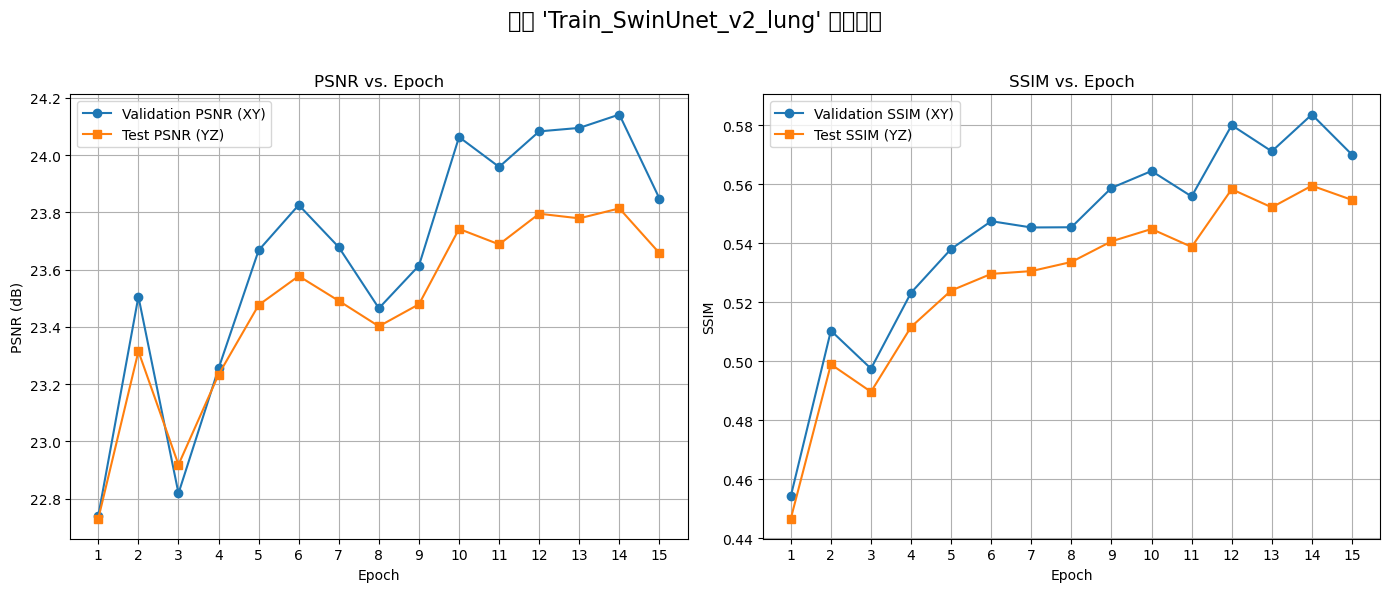

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import cv2
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------------------
# 1. 定义模型和 Dataset 类 (与训练时完全一致)
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4, d4 = self.up4(e4), self.dec4(torch.cat([self.up4(e4), e3], dim=1))
        u3, d3 = self.up3(d4), self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        u2, d2 = self.up2(d3), self.dec2(torch.cat([self.up2(d3), e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder, self.transform = patches_folder, transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()
checkpoint_dir = "Train_SwinUnet_v2_lung" # <-- 使用SwinUnet的权重文件夹
num_epochs = 15

# 准备 Dataloaders
val_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_xy"
all_val_fns = sorted([f for f in os.listdir(val_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_val_indices = list(range(len(all_val_fns)))
_, val_idxs = train_test_split(all_val_indices, test_size=0.25, random_state=42)
val_dataset = PlainLowHighDataset(val_patches_folder, val_idxs, all_val_fns, transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz"
all_test_fns = sorted([f for f in os.listdir(test_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_test_indices = list(range(len(all_test_fns)))
test_dataset = PlainLowHighDataset(test_patches_folder, all_test_indices, all_test_fns, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------------------
# 3. 定义评估函数
# ----------------------------------------
def evaluate_model(model, loader):
    total_psnr = total_ssim = n = 0
    model.eval()
    with torch.no_grad():
        for inp_t, tgt_t in loader:
            inp_t, tgt_t = inp_t.to(device), tgt_t.to(device)
            out_t = model(inp_t)
            
            pred_np = out_t.clamp(0, 1).cpu().squeeze().numpy()
            target_np = tgt_t.cpu().squeeze().numpy()
            
            total_psnr += psnr_metric(target_np, pred_np, data_range=1.0)
            total_ssim += ssim_metric(target_np, pred_np, data_range=1.0, channel_axis=None)
            n += 1
    return total_psnr / n, total_ssim / n

# ----------------------------------------
# 4. 循环评估所有Epoch并记录结果
# ----------------------------------------
epochs = list(range(1, num_epochs + 1))
val_psnrs, val_ssims = [], []
test_psnrs, test_ssims = [], []

print(f"开始在 {device} 上评估 '{checkpoint_dir}' 的所有模型...")

for epoch in tqdm(epochs, desc="评估进度"):
    # 构建权重文件路径，注意文件名格式
    ckpt_path = os.path.join(checkpoint_dir, f"SwinUnet_v2_hf_epoch{epoch:02d}.pth")
    
    # 实例化新模型并加载权重
    model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    
    # 在验证集和测试集上评估
    vp, vs = evaluate_model(model, val_loader)
    tp, ts = evaluate_model(model, test_loader)
    
    # 记录结果
    val_psnrs.append(vp)
    val_ssims.append(vs)
    test_psnrs.append(tp)
    test_ssims.append(ts)

# ----------------------------------------
# 5. 打印表格形式的结果
# ----------------------------------------
print("\n--- 评估结果汇总 ---")
print("="*60)
print(f"{'Epoch':<10}{'Val PSNR':<15}{'Val SSIM':<15}{'Test PSNR':<15}{'Test SSIM':<15}")
print("-"*60)
for i in range(num_epochs):
    print(f"{i+1:<10}{val_psnrs[i]:<15.4f}{val_ssims[i]:<15.4f}{test_psnrs[i]:<15.4f}{test_ssims[i]:<15.4f}")
print("="*60)


# ----------------------------------------
# 6. 绘制结果图表
# ----------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_psnrs, 'o-', label='Validation PSNR (XY)')
plt.plot(epochs, test_psnrs, 's-', label='Test PSNR (YZ)')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_ssims, 'o-', label='Validation SSIM (XY)')
plt.plot(epochs, test_ssims, 's-', label='Test SSIM (YZ)')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.suptitle(f"模型 '{checkpoint_dir}' 性能评估", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import timm
from torchvision import transforms

# ----------------------------------------
# 1. 定义与训练时完全一致的模型架构
# ----------------------------------------
# 确保这些定义与您训练模型时的代码完全相同
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
# 假设 block32_yz_003.jpg 在 "test_patches_YZ" 文件夹中
IMAGE_PATH = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz\block32_yz_003.jpg"
CHECKPOINT_DIR = "Train_SwinUnet_v2_lung"
EPOCH_TO_LOAD = 10
OUTPUT_DIR = "MSE_test"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

# ----------------------------------------
# 3. 加载模型权重
# ----------------------------------------
model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device) # pretrained=False,因为我们要加载自己的权重
checkpoint_filename = f"SwinUnet_v2_hf_epoch{EPOCH_TO_LOAD:02d}.pth"
checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"成功加载模型权重: {checkpoint_path}")

# ----------------------------------------
# 4. 加载和预处理图像
# ----------------------------------------
# 加载原始高分辨率图像 (Ground Truth)
gt_image_pil = Image.open(IMAGE_PATH).convert("L")
gt_image_np = np.array(gt_image_pil)
gt_tensor = transform(gt_image_pil).unsqueeze(0).to(device)

print(f"已加载图像: {IMAGE_PATH}")

# 创建模型的低分辨率输入
# 1. 归一化到 [0, 1]
gt_image_float = gt_image_np.astype(np.float32) / 255.0
# 2. 垂直下采样8倍
lr_image_np = cv2.resize(gt_image_float, (256, 32), interpolation=cv2.INTER_AREA)
# 3. 线性插值回原始尺寸
input_image_np = cv2.resize(lr_image_np, (256, 256), interpolation=cv2.INTER_LINEAR)
# 4. 转换为Tensor
input_tensor = torch.from_numpy(input_image_np).unsqueeze(0).unsqueeze(0).to(device)

print("已生成模型的低分辨率输入。")

# ----------------------------------------
# 5. 执行模型推理
# ----------------------------------------
with torch.no_grad():
    output_tensor = model(input_tensor)
print("模型推理完成。")

# ----------------------------------------
# 6. 保存结果图像
# ----------------------------------------
def tensor_to_image(tensor):
    """将 [0,1] 范围的Tensor转换为可保存的PIL Image对象"""
    arr = tensor.clamp(0, 1).cpu().squeeze().numpy()
    return Image.fromarray((arr * 255).round().astype(np.uint8))

# 获取不带后缀的文件名
base_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]

# 保存三张图片
path_input = os.path.join(OUTPUT_DIR, f"{base_name}_01_input.png")
path_output = os.path.join(OUTPUT_DIR, f"{base_name}_02_reconstructed.png")
path_gt = os.path.join(OUTPUT_DIR, f"{base_name}_03_ground_truth.png")

tensor_to_image(input_tensor).save(path_input)
tensor_to_image(output_tensor).save(path_output)
tensor_to_image(gt_tensor).save(path_gt)

print(f"\n结果已保存至 '{OUTPUT_DIR}/' 文件夹:")
print(f"  - 输入图像: {path_input}")
print(f"  - 重建图像: {path_output}")
print(f"  - 原始图像: {path_gt}")

C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_30756\862166045.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

成功加载模型权重: Train_SwinUnet_v2_lung\SwinUnet_v2_hf_epoch10.pth
已加载图像: C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz\block32_yz_003.jpg
已生成模型的低分辨率输入。
模型推理完成。

结果已保存至 'MSE_test/' 文件夹:
  - 输入图像: MSE_test\block32_yz_003_01_input.png
  - 重建图像: MSE_test\block32_yz_003_02_reconstructed.png
  - 原始图像: MSE_test\block32_yz_003_03_ground_truth.png
